In [386]:
import sympy as sym
import sympy.physics.mechanics as me
from sympy.abc import t as time
import pandas as pd
import seaborn as sns

import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt

import sys, os

sys.path.insert(1, os.path.join(sys.path[0], '../..'))
import custom_plot_objects as cpo

import ModelFramework as mf
import ModelFramework.Elements as ele
import ModelFramework.ExternalForces as ef
import FwtModels.RectWing as rw
import FwtModels.TwoDoF as TwoDof
from scipy.optimize import minimize
from matplotlib.lines import Line2D
import multiprocessing as mp

me.mechanics_printing()

In [387]:
dataset_name = 'Test'
panels = 10
# Set JEC Specific parameters
sm = mf.SymbolicModel.from_file('2DoF_Model.py')
p = TwoDof.base_params(panels)
sm = sm.subs({p.alpha_1.name:sym.atan(sym.sin(p.Lambda)*sym.sin(p.q[1]))})

p.rho.value = 1.225
p.s.value = 0.325
p.c_root.value = 0.15
p.c_tip.value = 0.15
p.m.value = 0.53
p.m_w.value = 1.5
p.f_0.value = 2.4
p.Lambda.value = np.deg2rad(10)
#p.a.value = [5.2,5.2,5.2,5.2,5.2,5.2,5,4,3,1]
p.a.value = [5,4.5,4,3.5,3,2.5,2,1.5,1,0.5]
p.c_d_max.value = 0

p.k_w.value = (p.f_0.value*2*np.pi)**2*(p.m_w.value+p.m.value)*0.9             # Stiffness of the inner wing
p.I_xx.value = 1/12*p.m.value*p.s.value**2          # FWT polar moment of inetia
#p.I_xx.value = 6.5/81*p.m.value*p.s.value**2 
p.l_com.value = p.s.value/2

vars_ls =[]
vars_ls.append((p.Lambda,np.deg2rad([10])))
vars_ls.append((p.V,np.linspace(0,40,80))) # V must be second
vars_ls.append((p.alpha_r,np.deg2rad([2.5,5,7.5,10])))

variables = [k for k,v in vars_ls]

flutdf = rw.eigen_perm_params(p,sm,vars_ls,calc_fixed_points=True,fp = np.array([0,np.deg2rad(-30)]))
flutdf.to_pickle(f'Test_FWT_free.pkl')

/Users/fintan/opt/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [388]:
#get list of symbols to key in model
variables = [k for k,v in vars_ls]
model_mini = sm.msubs(p.GetSubs(0,p.fp,ignore=variables))

In [389]:
nm = mf.NumericModel.from_SymbolicModel(p, model_mini)

In [390]:
(model_mini.ExtForces.Q()[0])
sm.f
p.g.value

In [391]:
p.V.value = 10
p.alpha_r.value = np.deg2rad(10)
x = [-0.055,0,np.deg2rad(-1),0]
nm.deriv(0,x,p.GetNumericTuple(x,0))

In [392]:
p.V.value = 10
p.alpha_r.value = np.deg2rad(10)
x = [0,0,np.deg2rad(90),0]
tup = p.GetNumericTuple(x,0)
-nm.f_func(tup,x)+nm.ExtForces(tup,x,0)

array([[-19.9143   ],
       [ -0.3236132]])

In [393]:
def Calc_coast(numeric_model,p,ic):
    # Create Objetive Function
    def objective_func(x, ic):
        y=[0]*4
        y[0] = ic[0]
        y[1] = ic[1]
        y[2] = x[0]
        tup = p.GetNumericTuple(y, 0)  
        forces = -numeric_model.f_func(tup,y)+numeric_model.ExtForces(tup,y,0)
        return forces[1][0]**2
    # find left and right cruise angle
    res = minimize(objective_func, [0], args=(ic,))
    if res.success:
        return [ic[0],ic[1],res.x[0],0]
    raise Exception('Failed to calulate coast angles')

In [394]:
p.V.value = 10
p.alpha_r.value = np.deg2rad(10)
Calc_coast(nm,p,[0,0])

In [395]:
np.pi/2

In [396]:
sm.ExtForces.Q()

⎡                ⎛                              s⋅q₁̇             ⎞           
⎢                ⎜                            - ──── + cos(q₁)⋅q₀̇⎟           
⎢ 2              ⎜                               20              ⎟            
⎢V ⋅a₀⋅cᵣₒₒₜ⋅ρ⋅s⋅⎜αᵣ + atan(sin(Λ)⋅sin(q₁)) - ───────────────────⎟⋅cos(q₁)   V
⎢                ⎝                                     V         ⎠            
⎢───────────────────────────────────────────────────────────────────────── + ─
⎢                                    20                                       
⎢                                                                             
⎢                                           ⎛                              s⋅q
⎢                                           ⎜                            - ───
⎢                           2             2 ⎜                               20
⎢                          V ⋅a₀⋅cᵣₒₒₜ⋅ρ⋅s ⋅⎜αᵣ + atan(sin(Λ)⋅sin(q₁)) - ─────
⎢                                           ⎝       

In [397]:
sm.f

⎡                                         2⎤
⎢g⋅m + g⋅m_w + k_w⋅q₀ + l_com⋅m⋅sin(q₁)⋅q₁̇ ⎥
⎢                                          ⎥
⎣            -g⋅l_com⋅m⋅cos(q₁)            ⎦

In [398]:
flutdf = pd.DataFrame()


angles = [-30,-15,0,15,30]

ls = []
#for ang in angles:
dat = pd.read_pickle(f'Test_FWT_free.pkl')
ls.append(dat)
    
flutdf = pd.concat(ls, ignore_index=True, sort=False)

flutdf = flutdf.reset_index(drop=True)
flutdf['Damping [%]'] = flutdf['Damping']*-100
flutdf['Coast Angle [Deg]'] = np.rad2deg([i[-1] for i in flutdf['q']])
flutdf['Flare Angle [Deg]'] = pd.Categorical(np.rad2deg(flutdf['Lambda']))
flutdf['AoA [Deg]'] = pd.Categorical(np.rad2deg(flutdf['alpha_r']))
flutdf['Mode'] = pd.Categorical(flutdf['Mode'])
flutdf['Stable'] = pd.Categorical(flutdf['Stable'])

In [399]:
filter_dict = {'Flare Angle [Deg]':[10],'Mode':[0,1],'Stable':None}

data = cpo.GetReducedDataSet(flutdf,filter_dict)

In [400]:
data

,Real,Imag,Frequency,Damping,Stable,Eigen Vector,Mode,Lambda,V,alpha_r,q,Damping [%],Coast Angle [Deg],Flare Angle [Deg],AoA [Deg]
0,0.000000e+00,7.769764,1.236596,6.123234e-17,True,"[1.3874824369796132e-19j, -0.1276511289785803j...",0,0.174533,0.000000,0.043633,"[-0.04793406691412676, 1.5707963267948966]",-6.123234e-15,90.000000,10.0,2.5
1,0.000000e+00,14.305807,2.276840,6.123234e-17,True,"[0.06973152840171891j, 0j, (-0.997565794294672...",1,0.174533,0.000000,0.043633,"[-0.04793406691412676, 1.5707963267948966]",-6.123234e-15,90.000000,10.0,2.5
2,-2.863276e-02,7.769711,1.236596,-3.685152e-03,True,[(1.6026870095732971e-09+3.3620535382303144e-0...,0,0.174533,0.506329,0.043633,"[-0.04793406024060602, 1.5701853643726633]",3.685152e-01,89.964994,10.0,2.5
3,-2.612214e-09,14.305809,2.276840,-1.825981e-10,True,[(-1.1793184164239458e-09+0.0697305300674967j)...,1,0.174533,0.506329,0.043633,"[-0.04793406024060602, 1.5701853643726633]",1.825981e-08,89.964994,10.0,2.5
4,-5.726549e-02,7.769553,1.236596,-7.370299e-03,True,[(1.2788740520305429e-08+1.3447455281513572e-0...,0,0.174533,1.012658,0.043633,"[-0.047933960138262476, 1.56835248017535]",7.370299e-01,89.859978,10.0,2.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
635,-2.433422e-02,14.287857,2.273986,-1.703137e-03,True,[(-0.001689982118276106-0.014428084240752233j)...,1,0.174533,38.987342,0.174533,"[-0.041751772641303746, -0.9421546164557674]",1.703137e-01,-53.981483,10.0,10.0
636,-2.304558e+00,7.214526,1.205386,-3.042858e-01,True,[(0.0003146754058035002-0.0031687375193199603j...,0,0.174533,39.493671,0.174533,"[-0.04204321492921939, -0.9593911148350961]",3.042858e+01,-54.969062,10.0,10.0
637,-2.382429e-02,14.284736,2.273489,-1.667812e-03,True,[(-0.001742682172814958-0.014816545989492743j)...,1,0.174533,39.493671,0.174533,"[-0.04204321492921939, -0.9593911148350961]",1.667812e-01,-54.969062,10.0,10.0
638,-2.329830e+00,7.151295,1.197043,-3.097665e-01,True,[(0.00028938583915424075-0.0031278628986177036...,0,0.174533,40.000000,0.174533,"[-0.04232325379568561, -0.9761585739996986]",3.097665e+01,-55.929766,10.0,10.0


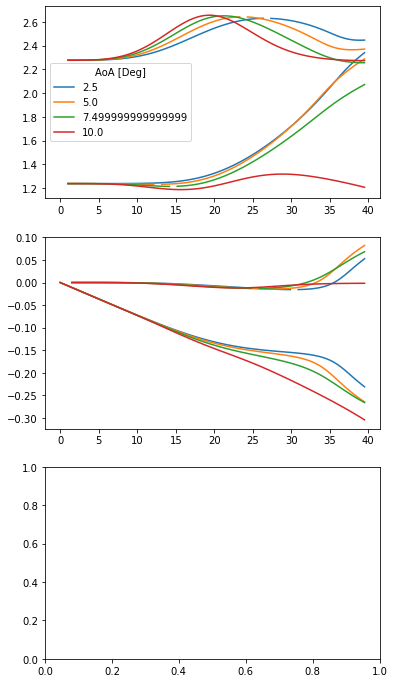

In [401]:
fig, axes = plt.subplots(3,1,figsize=(6,12))  
cpo.FlutterPlot(data,x = 'V',style=None, Modes = 'Mode',hue = 'AoA [Deg]',y = 'Frequency',ax = axes[0],legend=True)
cpo.FlutterPlot(data,x = 'V',style=None, Modes = 'Mode',hue = 'AoA [Deg]',y = 'Damping',ax = axes[1],legend=False)